# HATS Import of ZTF DR22

## Problem

The ZTF DR22 dataset, available on epyc as a collection of `.parquet` files, had some performance and correctness problems when trying to import it into HATS using the `file_reader="parquet"` import argument.  This notebook demonstrates the use of the `file_reader="indexed_parquet"` import argument to read the files as batches.

The size, number, membership, and locality of the file names in these batches were important tuning parameters, without which the import would either not complete, or require an intractable amount of time.  A summary of the problems:

1. There are 176561 parquet files in the ZTF.  Using `file_reader="parquet"` results in 176k jobs,
   which makes the mapping phase take ~5h.
2. The sizes of the parquet files follow a log distribution, so that allowing one file per job results
   in uneven load across the dask cluster.
3. Some of the parquet files were empty, having only metadata, and these empty files caused errors
   in the reducing stage.  These files *also* had schema which differed from the data-bearing files,
   and it's likely that these schema differences were the proximate cause of the error.
   Specifically, fields like `hmjd` were modeled as `double` rather than `list<double>` for the empty
   files.
4. Using the `binpacking` module to distribute files across evenly-sized batches was not effective since
   it mixed together `.parquet` files from many different ZTF fields into the same batch, increasing
   the chance that the mapping and splitting algorithms would have to keep moving between files, defeating
   caching and increasing resource usage.

This tracking issue details the discovery and solutions of each of the above problems: https://github.com/astronomy-commons/hats-import/issues/452

## Approach

To resolve the above, the approach was to create a set of indexed batch files that would:

1. Result in an optimal number of tasks (between 1k and 5k, historically).
2. Keep `.parquet` files from ZTF fields together when possible.
3. Omit data-empty `.parquet` files.
4. Otherwise distribute the volume of data equally among these batches.

In [2]:
import glob
from pathlib import Path

input_path = "/data3/epyc/data3/hats/raw/ztf/lc_dr22"
parquet_list = glob.glob(f"{input_path}/**/*.parquet", recursive=True)

# Ensure that the list is lexicographically sorted, keeping ZTF fields together.
parquet_list.sort()

print(f"Parquet files found: {len(parquet_list)}")

file_sizes = [Path(p).stat().st_size for p in parquet_list]

Parquet files found: 176561


Text(0.5, 1.0, 'File Count by Size (MiB)')

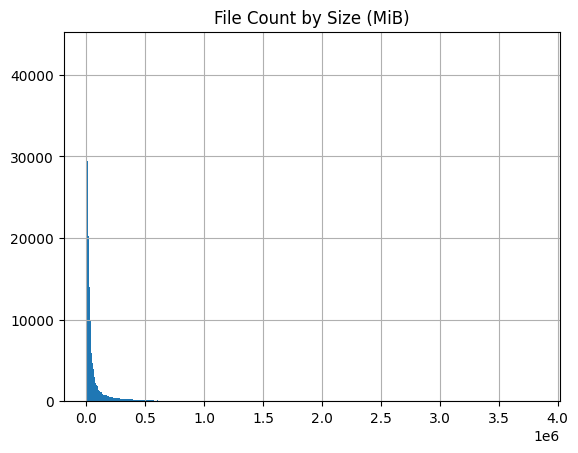

In [25]:
# Show the file size distribution in MiB
%matplotlib inline

from matplotlib import pyplot as plt
import pandas as pd

h = (pd.DataFrame(file_sizes) / 1024*2).hist(bins=512)
ax = h[0][0]
ax.set_title("File Count by Size (MiB)")

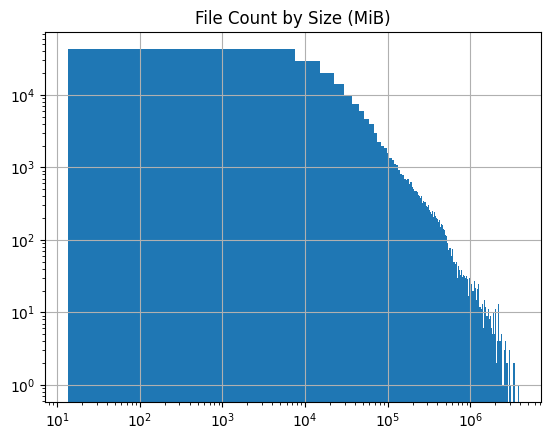

In [30]:
# Demonstrate that it is a log-log distribution
h = (pd.DataFrame(file_sizes) / 1024*2).hist(bins=512)
ax = h[0][0]
ax.set_title("File Count by Size (MiB)")
ax.set_xscale("log")
ax.set_yscale("log")

In [46]:
import pyarrow.parquet as pq
import tqdm

# Define function for generating batch indexes
def generate_batch_indexes(sizes_and_names: list[tuple[int, str]],
                           prefix: str,
                           bin_size: int) -> tuple[list, list]:
    batch_count = 0
    bytes_in_bin = 0
    file_count = 0
    f_out = None
    
    batch_stats = []
    empty_files = []

    def cycle_batch(done = False):
        nonlocal bytes_in_bin, batch_count, file_count, f_out
        if f_out is not None:
            f_out.close()
            batch_stats.append((bytes_in_bin, file_count))
        bytes_in_bin = 0
        file_count = 0
        batch_count += 1
        if not done:
            f_out = open(f"{prefix}_{batch_count:04d}.batch", "w")

    cycle_batch()
    for file_sz, file_name in tqdm.tqdm(sizes_and_names):
        # Before deciding whether to include this file, make sure it isn't empty
        nr = pq.read_metadata(file_name).num_rows
        if nr == 0:
            empty_files.append(file_name)
            continue
        file_count += 1
        if bytes_in_bin > bin_size:
            cycle_batch()
        f_out.write(file_name + '\n')
        bytes_in_bin += file_sz
    cycle_batch(done=True)
    return batch_stats, empty_files

In [47]:
sizes_and_names = list(zip(file_sizes, parquet_list))

In [75]:
# Choose an output directory hosted on a fast disk.
# Today (2024-12-13) this operation is taking ~100X longer on epyc than I've
# seen before.  As there has been no change in logic, I can only blame heavy
# I/O loading by other users on epyc.  It used to take a couple of minutes,
# and now gives estimates of 1 to 4 hours.  That's a long time to wait.
# Still, if you don't do this, and try to read the parquet files directly,
# you'll be waiting a lot longer than that; the job won't ever complete.

batch_path = "./sample_batch"
Path(batch_path).mkdir(parents=True, exist_ok=True)
batch_stats, empty_files = generate_batch_indexes(sizes_and_names, f"{batch_path}/b", 1.5 * 1024**3)

 12%|█▏        | 22059/176561 [11:01<1:17:10, 33.36it/s]  


KeyboardInterrupt: 

In [56]:
len(batch_stats), empty_files

(999, [])

In [70]:
output_path = "/data3/epyc/data3/hats/catalogs/ztf_dr22/"

In [74]:
from hats_import.catalog.arguments import ImportArguments

# Get the list of batch files generated earlier
batch_files = glob.glob(batch_path + "/b_*.batch")
output_path = "/data3/epyc/data3/hats/catalogs/ztf_dr22"
output_artifact = "ztf_lc_test"

# Use that to drive the import, making use of "indexed_parquet"
import_args = ImportArguments(
    sort_columns="objectid",
    ra_column="objra",
    dec_column="objdec",
    input_file_list=batch_files,
    output_artifact_name=output_artifact,
    output_path=output_path,
    file_reader="indexed_parquet",
)

In [ ]:
# Run the pipeline.  This can take 8 to 10 hours on epyc.
# Don't uncomment and run this cell until you're ready to commit.
#
# The number of workers and amount of memory per worker here is
# nearly a minimum, on epyc.  If the workers do not have at least
# 64GB apiece, they will run out of memory during the splitting
# phase.

from dask.distributed import Client
from hats_import.pipeline import pipeline_with_client
# with Client(n_workers=16, memory_limit="64GB", threads_per_worker=2,
#             local_directory="/epyc/data3/hats/tmp") as client:
#     pipeline_with_client(import_args, client)

In [71]:
# Verify that the completed output catalog is valid
from hats.io.validation import is_valid_catalog
ztf_dr22_path = output_path + "/" + "ztf_lc"
is_valid_catalog(ztf_dr22_path)

True